# Fundamentals of Machine Learning - 2022
## Report 1 - Classification task
Pablo Chehade  
Última modificación: 13/09/2022


### Introducción

El objetivo es construir un modelo de machine learning que sea capaz de predecir el target de un problema lo mejor posible, utilizando en el camino las herramientas y conceptos enseñados en clase.  
- TARGET: clase de árbol más frecuente en una celda de 30m por 30m que contiene distintos tipos de árboles
- PREDICTOR VARIABLES: info. geográfica sobre tal celda, como por ejemplo pendiente del suelo, distacia a cuerpos de agua o posibles fire sports, etc.  

Para tal fin se puede experimentar con solo dos modelos: random forests y xgboost  

Además, como estimación del error se empleó solo el parámetro Accuracy definido como el nro de predicciones correctas sobre el nro total de predicciones. Formalmente, se deberían tener en cuenta otros estimadores del error, como Precision o Recall, pero se optó solo por Accuracy por simplicidad. Además, no se tiene suficiente información del problema como para evaluar la necesidad de hacer un trade off entre los estimadores de error nombrados. Esto es, no se sabe cuál es la relación entre positivos, falsos positivos, falsos negativos, ... que busca quien planteó el problema.

En primer lugar, se realizó un análisis exploratorio de los datos. Un primer vistazo sobre todo el set de datos y un análisis más detallado sobre el set de training. Es necesario aclarar que se decidió hacer una separación entre training y test, de modo de cuantificar el error del modelo final. En segundo lugar, se implementaron los modelos mencionados. En cada uno de ellos se comenzó con un modelo primitivo con el objetivo de evaluar el overfitting del mismo. Luego, se implementó grid search y cross validation, de modo de obtener el mejor conjunto de hiperparámetros. Después, se analizó la importancia de los atributos, construyendo un modelo con menor error y a su ver menor cantidad de atributos. Por último, se eligió el modelo que tuviese menor error.

In [9]:
#Importo librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split #Para dividir el dataset en 2 partes
from sklearn.metrics import accuracy_score

AttributeError: module 'numpy' has no attribute 'square'

### Análisis Exploratorio de los Datos

#### Primer vistazo a los datos

In [68]:
#Importo el dataset con pandas
data = pd.read_csv('datasets/train_r1.csv')

In [69]:
#Imprimo las primeras columnas
data.head()

,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_area_silvestre,clase_suelo,dosel_forestal
0,2596,51,3,258,0,510,221,232,148,6279,1,29,5
1,2804,139,9,268,65,3180,234,238,135,6121,1,12,2
2,2785,155,18,242,118,3090,238,238,122,6211,1,30,2
3,2595,45,2,153,-1,391,220,234,150,6172,1,29,5
4,2579,132,6,300,-15,67,230,237,140,6031,1,29,2


In [70]:
#Imprimo info gral del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464810 entries, 0 to 464809
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   altura                464810 non-null  int64
 1   exposicion            464810 non-null  int64
 2   inclinacion_suelo     464810 non-null  int64
 3   distancia_agua        464810 non-null  int64
 4   altura_agua           464810 non-null  int64
 5   distancia_caminos     464810 non-null  int64
 6   sombra_maniana        464810 non-null  int64
 7   sombra_mediodia       464810 non-null  int64
 8   sombra_tarde          464810 non-null  int64
 9   distancia_fuego       464810 non-null  int64
 10  clase_area_silvestre  464810 non-null  int64
 11  clase_suelo           464810 non-null  int64
 12  dosel_forestal        464810 non-null  int64
dtypes: int64(13)
memory usage: 46.1 MB


In [ ]:
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 464810 entries, 0 to 464809
# Data columns (total 13 columns):
#  #   Column                Non-Null Count   Dtype
# ---  ------                --------------   -----
#  0   altura                464810 non-null  int64
#  1   exposicion            464810 non-null  int64
#  2   inclinacion_suelo     464810 non-null  int64
#  3   distancia_agua        464810 non-null  int64
#  4   altura_agua           464810 non-null  int64
#  5   distancia_caminos     464810 non-null  int64
#  6   sombra_maniana        464810 non-null  int64
#  7   sombra_mediodia       464810 non-null  int64
#  8   sombra_tarde          464810 non-null  int64
#  9   distancia_fuego       464810 non-null  int64
#  10  clase_area_silvestre  464810 non-null  int64
#  11  clase_suelo           464810 non-null  int64
#  12  dosel_forestal        464810 non-null  int64
# dtypes: int64(13)
# memory usage: 46.1 MB

In [71]:
#Veo las categorías de las variables categóricas y la frecuencia de cada una:
#data["clase_area_silvestre"].value_counts()
#data["clase_suelo"].value_counts()
data["dosel_forestal"].value_counts()

2    226596
1    169395
3     28602
7     16406
6     13993
5      7614
4      2204
Name: dosel_forestal, dtype: int64

In [ ]:
# 2    226596
# 1    169395
# 3     28602
# 7     16406
# 6     13993
# 5      7614
# 4      2204
# Name: dosel_forestal, dtype: int64

##### Observaciones

Se tienen 12 variables predictoras y 1 target (clase_forestal). Tipos de variables:
- Las variables exposicion (columna 2) e inclinacion_suelo (columna 3) se encuentran en grados.
- Las variables sombra_maniana (columna 7), sombra_mediodia (columna 8) y sombra_tarde (columna 9) son enteros en el intervalo [0,255].
- Las variables clase_area_silvestre (columna 11), clase_suelo (columna 12) y dosel_forestal (columna 13) son categóricas. La primera tiene 4 categorías, la 2da, 40 y la 3ra, 7. Los nros enteros representan clases.  
- El resto de variables son distancias en metro  

Datos nulos: No hay datos nulos en el dataset.

#### Separo entre Train y Test

Tengo que poner en test_size al menos un nro bien pequeño cosa de que haga el random sobre el train_set

In [72]:
#Divido el dataset entre train y test. A partir de ahora no utilizaré test
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42) ### Fijamos 20% para test y 42 es el random state para poder reproducir los resultados.

#Guardo el test set en un archivo pickle
test_set.to_pickle("datasets/data_test.pkl")

#### Análisis Exploratorio sobre el set de Train

Analizo las distribuciones marginales de cada atributo y las correlaciones entre los mismos. Como norma general, es bueno que haya variables correlacionadas con el target, pero no que haya atributos correlacionados entre sí.

ELIMINAR PARA EL INFORME FINAL:
Uno necesita variables correlacionadas con el target porque justamente es lo que queremos predecir. Pero no está bueno que haya correlación entre variables porque en un espacio de dimensión n, harían que vivan n un espacio n-1. Eso para hacer ajustes de regresión trae problemas, pero para clasificación no.


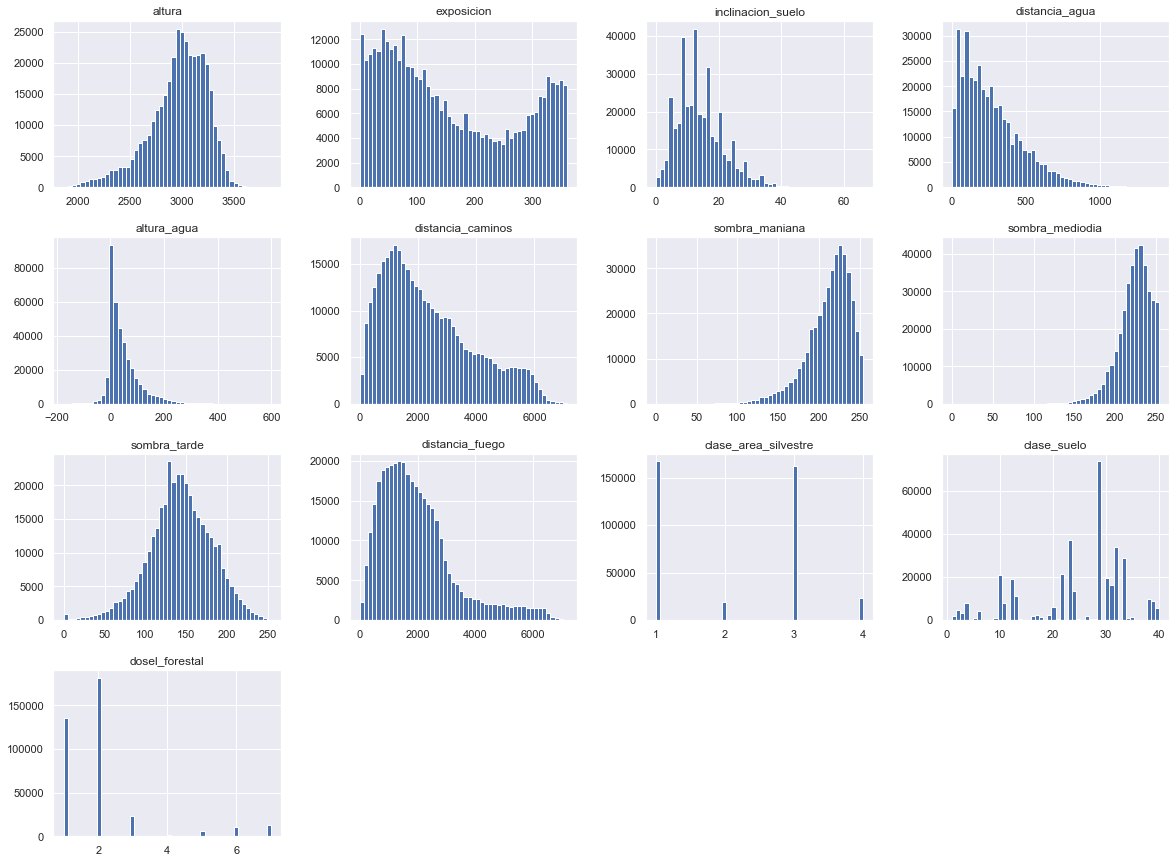

In [73]:
#Hago un histograma de cada atributo
train_set.hist(bins=50, figsize=(20,15));


In [74]:
#Analizo correlaciones entre atributos
corr_matrix = train_set.corr()
#plt.matshow(corr_matrix) #No aporta mucha info. la matriz de correlaciones

corr_matrix = train_set.corr()
print(corr_matrix["dosel_forestal"].sort_values(ascending=True))

altura                 -0.268298
clase_suelo            -0.163547
distancia_caminos      -0.152848
distancia_fuego        -0.108455
sombra_mediodia        -0.095722
sombra_tarde           -0.048833
sombra_maniana         -0.034310
distancia_agua         -0.021745
exposicion              0.017364
altura_agua             0.080170
inclinacion_suelo       0.147542
clase_area_silvestre    0.276400
dosel_forestal          1.000000
Name: dosel_forestal, dtype: float64


In [ ]:
# altura                 -0.268298
# clase_suelo            -0.163547
# distancia_caminos      -0.152848
# distancia_fuego        -0.108455
# sombra_mediodia        -0.095722
# sombra_tarde           -0.048833
# sombra_maniana         -0.034310
# distancia_agua         -0.021745
# exposicion              0.017364
# altura_agua             0.080170
# inclinacion_suelo       0.147542
# clase_area_silvestre    0.276400
# dosel_forestal          1.000000
# Name: dosel_forestal, dtype: float64

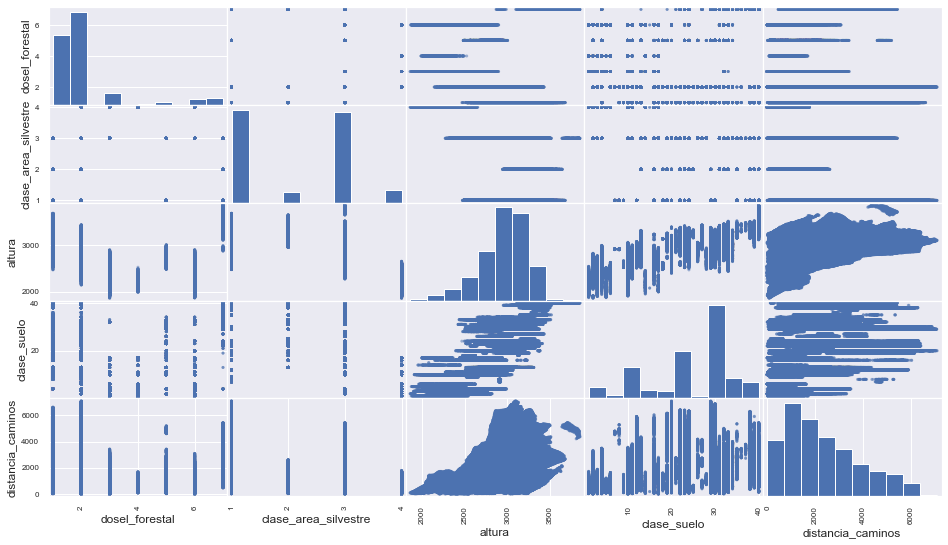

In [75]:
#Las correlaciones de mayor módulo son clase_area_silvestre, altura, clase_suelo, distancia_caminos e inclinacion_suelo.

feat_corr = ["dosel_forestal","clase_area_silvestre", "altura", "clase_suelo", "distancia_caminos"]
pd.plotting.scatter_matrix(train_set[feat_corr], figsize=(16, 9));

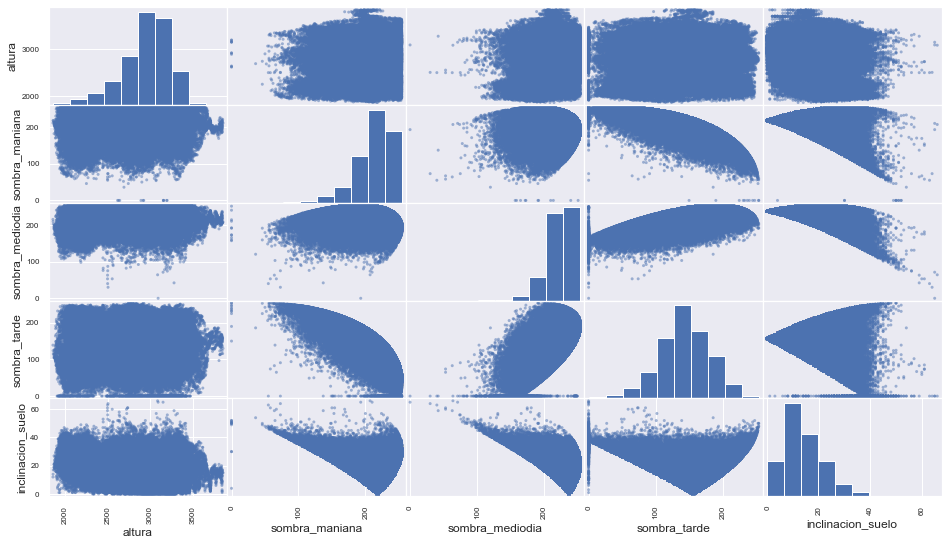

In [76]:
#Intuitivamente, también esperaría que las variables altura, las tres de sombra e inclinacion_suelo estén correlacionadas. Me fijo si realmente es así
feat_corr = ["altura", "sombra_maniana", "sombra_mediodia", "sombra_tarde", "inclinacion_suelo"]
pd.plotting.scatter_matrix(train_set[feat_corr], figsize=(16, 9));

##### Observaciones

1. De los histogramas se obtiene que hay variables con distribución sesgada, tal como inclinacion_suelo, distancia_agua, entre otras. Pero también existen otras simétricas, como sombra_tarde. Por otro lado, no son de gran utilidad los histogramas de las variables categóricas, salvo para ver la proporción de datos para cada categoría. Por ejemplo, en el caso de la variable target dosel_forestal la clase 2 está en mayor proporción que las demás, mientras que la clase 4 es la de menor proporción.
2. De la matriz de correlación se obtiene que
* Las comparaciones entre variables categóricas no son muy útiles. La única info. que se obtiene es que existen datos que pertenecen a una determinada categoría de una variable pero nunca pertenecen a una determinada categoría de otra variable. Por ej, parece no haber datos en la categoría 3 de dosel_forestal y categoría 2 de clase_area_silvestre. Quizás podríamos obtener mayor información si supiéramos qué significa cada categoría.
* Altura y clase_suelo parecen estar correlacionadas. En base a lo mencionado anteriormente, esto puede traer problemas en un futuro.
* Altura y distancia_caminos también parecen estar correlacionadas. Podríamos crear una nueva variable que sea el cociente entre la variable distancia_caminos y altura.
* Las variables de sombra tienen correlación entre sí, pero no se observa una clara correlación de las mismas con altura. Podría crear una variable que sea media de sombra_maniana, sombra_mediodia y sombra_tarde para ver si ayuda en algo al modelo.


#### Creación de nuevos features

En base a lo observado en el análisis exploratorio de los datos, podría ser útil crear las variables
* sombra_mean: media de sombra_maniana, sombra_mediodia y sombra_tarde}
* razon_distcaminos_altura: razón entre las variables distancia_caminos y altura.

In [77]:
#Creo nuevas variables
sombra_mean = (train_set["sombra_maniana"] + train_set["sombra_mediodia"] + train_set["sombra_tarde"])/3
train_set["sombra_mean"] = sombra_mean

razon_distcaminos_altura = train_set["distancia_caminos"]/train_set["altura"]
train_set["razon_distcaminos_altura"] = razon_distcaminos_altura

#Analizo nuevamente las correlaciones
corr_matrix = train_set.corr()
print(corr_matrix["dosel_forestal"].sort_values(ascending=True))

altura                     -0.268298
clase_suelo                -0.163547
distancia_caminos          -0.152848
razon_distcaminos_altura   -0.142516
distancia_fuego            -0.108455
sombra_mean                -0.107742
sombra_mediodia            -0.095722
sombra_tarde               -0.048833
sombra_maniana             -0.034310
distancia_agua             -0.021745
exposicion                  0.017364
altura_agua                 0.080170
inclinacion_suelo           0.147542
clase_area_silvestre        0.276400
dosel_forestal              1.000000
Name: dosel_forestal, dtype: float64


In [ ]:
# altura                     -0.268298
# clase_suelo                -0.163547
# distancia_caminos          -0.152848
# razon_distcaminos_altura   -0.142516
# distancia_fuego            -0.108455
# sombra_mean                -0.107742
# sombra_mediodia            -0.095722
# sombra_tarde               -0.048833
# sombra_maniana             -0.034310
# distancia_agua             -0.021745
# exposicion                  0.017364
# altura_agua                 0.080170
# inclinacion_suelo           0.147542
# clase_area_silvestre        0.276400
# dosel_forestal              1.000000
# Name: dosel_forestal, dtype: float64

##### Observaciones

La nueva variable sombra_mean tiene ligeramente mayor correlación que las variables sombra_maniana, sombra_mediodia y sombra_tarde por separado
La nueva variable razon_distcaminos_altura tiene menor correlación en módulo que distancia_caminos.

In [78]:
#Guardo los datos
train_set.to_pickle("datasets/data_train.pkl")

### Random Forest

Los árboles son robustos a la no normalización, por lo que no es necesario hacer standarización. Además, no hay missing values en los datos, por lo que no hay que trabajar con NaNs.

In [79]:
#Divido el train_set entre train_predictors y train_target
train_predictors = train_set.drop("dosel_forestal", axis=1)
train_target = train_set["dosel_forestal"].copy()


#### Modelo simple con parámetros por default

In [80]:
from sklearn.ensemble import RandomForestClassifier
#Creo el modelo
RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42, n_estimators = 100, max_depth = 10, min_samples_split = 2, min_samples_leaf = 1)
#Lo entreno
RFmodel.fit(train_predictors, train_target)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

##### Gráficos y cálculo de error

El objetivo es ver cuán bien ajusta el modelo a los datos de train. Esto puede llegar a no ser tan visible porque muchas variables son categóricas. De hecho, las variables con mayor correlación con el target son clase_area_silvestre (categórica) y altura (continua).



In [81]:
# import seaborn as sns

# # Apply the default theme
# sns.set_theme()
# #El siguiente gráfico está bueno pero es poco representativo porque no se pueden ver bien los datos (son muchos)
# sns.catplot(data=train_set, x="dosel_forestal", y="altura", jitter=0.25);
# #Podemos hacer el mismo gráfico pero con una porción más pequeña del train set:
# train_set_small = train_set.iloc[:1000] #Si bien los índices van de 0 a 1000, son aleatorios porque en la división entre train y test se mezclaron los datos.

# #En el siguiente gráfico, la separación respecto a la vertical sólo se emplea para separar los puntos, no está asignado a ninguna variable
# sns.catplot(data=train_set_small, x="dosel_forestal", y="altura", jitter=0.25);
# #En el siguiente gráfico, la separación es tal que intenta no superponer puntos. Está buena pero no es útil para muchos datos.
# sns.catplot(data=train_set_small, x="dosel_forestal", y="altura", kind="swarm");

# #Me quedo con el primer gráfico. Pero para que sea representativo voy a hacerlo sobre varios conjuntos de train_set_small. La diferencia es enorme de todos modos. En los gráficos tomo solo 1.000 datos, cuando en la práctica hay cerca de 370.000.


ORDEN: 
1er gráfico: Altura vs clase_forestal: 
2do gráfico: Altura vs las predicciones de clase_forestal: 


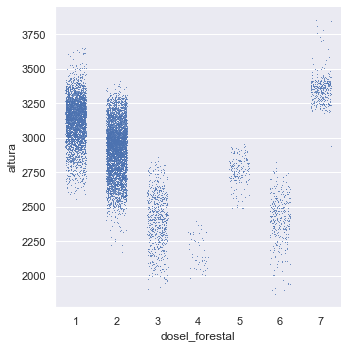

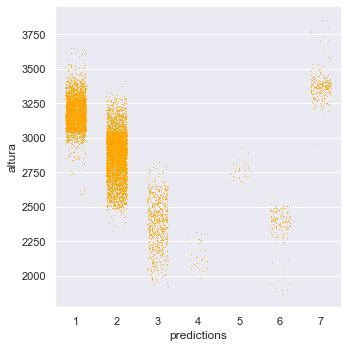

In [82]:
import seaborn as sns

# Apply the default theme
sns.set_theme()

#Hago las predicciones con el modelo
train_predictions = RFmodel.predict(train_predictors)
#Las junto en una nueva columna del train_set
plot_set = train_set.copy()
plot_set["predictions"] = train_predictions

for i in range(1):
    #Divido el set en sets más pequeños
    plot_set_small = plot_set.iloc[10000*i:10000*(1+i)]
    print("ORDEN: \n1er gráfico: Altura vs clase_forestal: \n2do gráfico: Altura vs las predicciones de clase_forestal: ")
    sns.catplot(data=plot_set_small, x="dosel_forestal", y="altura", jitter=0.25, size = 1);
    sns.catplot(data=plot_set_small, x="predictions", y="altura", jitter=0.25, size = 1, color="orange");


In [83]:
#Error sobre el train set
RFmodel_error = accuracy_score(train_target, RFmodel.predict(train_predictors))
print("Accuracy: ", RFmodel_error*100, " %" )


Accuracy:  79.04573911921  %


In [ ]:
# Accuracy:  79.04573911921  %

##### Observaciones
* Con los parámetros por default el modelo tiene error nulo (accuracy de 100%) está overfitteando. Cambiando el parámetro max_depth a 10, el modelo tiene un error asociado y por lo tanto no overfittea (al menos no tanto como antes). Por default la variable max_depth está en None, es decir, los nodos se expanden hasta que las leaves sean puras, de ahí el overfitting quizás.
* Ambos gráficos presentados son similares. Quizás la diferencia más notable sea que las clases 5 y 6 predichas tienen menos datos en comparación a los datos. Esto se refleja en un accuracy del 79%.

#### Cross Validation

Para evaluar el desempeño del modelo sin utilizar la partición de test se puede emplear cross validation. Se tendrán en cuenta solo 5 subconjuntos de modo de disminuir el tiempo de ejecución del código

In [84]:
from sklearn.model_selection import cross_val_score

### definamos una función para presentar los resultados 
def display_scores(scores):
    print("Scores:", scores) #Score de cada partición
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    

In [85]:
scores = cross_val_score(RFmodel, train_predictors, train_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones
display_scores(scores)


Scores: [0.78612344 0.78242571 0.78450988 0.78398257 0.78368675]
Mean: 0.7841456707525201
Standard deviation: 0.0012033025158397727


In [ ]:
# Scores: [0.78612344 0.78242571 0.78450988 0.78398257 0.78368675]
# Mean: 0.7841456707525201
# Standard deviation: 0.0012033025158397727

##### Observaciones

Los scores son similares, es decir, la desviación estándard es pequeña. Si no lo fueran, significaría que en algún caso está haciendo overfitting.

#### Grid search

Los parámetros utilizados fueron por default (salvo max_depth). Para mejorar el modelo es necesario encontrar la óptima configuración de hiperparámetros. El primer acercamiento consiste en definir una grilla de hiperparámetros, hacer cross validation sobre cada configuración y comparar el valor medio del score. La mejor configuración de hiperparámetros sería aquella con mejor score.

Es necesario aclarar que quizás lo mejor sea hacer grid search sobre el "mejor modelo", es decir, sobre Radom Forest o XgBoost. Pero como a priori no se tiene en claro "la mejor elección de parámetros", es preferible hacer un mini grid search en cada uno de los modelos y luego comparo entre los mejores modelos, para luego hacer un grid seach más grande. De todos modos, este último paso no realizará.

¿Qué parámetros se pueden variar del RandomForest? Hago una lista de los parámetros, junto a una breve explicación, el valor por default y el rango en el que voy a variar cada uno de ellos al hacer grid search

1. n_estimators: nro de trees en el forest  
* Default: 100  
* Variación: [50,100,200]
2. criterion: función para medir el error en el split
* Default: "gini"  
* Variación: ["gini", "entropy", "log_loss"]  
3. max_depth: máxima depth en el tree
* Default = None, es decir, los nodos se expanden hasta que todas las leaves sean puras  
* Variación: [2, 5, 10]
4. min_samples_split: nro minimo de samples necesarios para hacer un split en un nodo interno
* Default: 2
* Variación: [2,4]
5. min:samples_leaf: nro mínimo de samples necesario para estar en un leaf node.
* Default: 1
* Variación: [1,2]
6. max_features: nro de atributos considerados al buscar el mejor split. Sea p la cantidad total de variables.
* Default: sqrt(p)
* Variación: ["sqrt", "log2"]
7. boostrap (bool): usar o no boostraped samples?
* Default: True
* Variación: True
8. oob_score (bool): usar o no out-of-bag samples para estimar el score de generalización
* Default: False
* Variación: True. La mejor opción para evitar overfitting sería elegir el mejor modelo como aquel que sea capaz de generalizar y, por lo tanto, capaz de predecir datos con los que no fue entrenado. En out-of-bag error, se estima el error a partir de los datos que no cayaron en cada boostraped sample en particular.
9. n_jobs: nro de jobs que se pueden hacer en paralelo. Por defecto tengo que poner -1 para que se usen todos los procesadores. Para dar una idea del orden de magnitud, la primera vez que hice el fit le tomó 1:41 s usando un procesador y 21 s usando todos los procesadores.
* Default: None
* Variación: -1
10. random_state: controla la aleatoriedad del boostraping de los samples. Es útil, entiendo, para poder tener reproducibilidad de los resultados
* Default: None
* Variación: 42

In [86]:
from sklearn.model_selection import GridSearchCV

#Defino los parámetros a variar:





param_grid = [
    {'n_estimators': [100], 'criterion':["entropy"],  'max_depth':[20, 40, 60, 100], 'min_samples_split':[2, 8], 'min_samples_leaf':[1, 4], 'max_features':["sqrt"], 'oob_score':[True]},
  ]


#Defino el modelo
RFmodel_GS = RandomForestClassifier(n_jobs = -1, random_state=42, oob_score = True)

#Test 1: entrena sobre 5 folds, un total de 5*4*3 = 60 trainings. Le tomó a mi computadora 12 minutos.
#Test 2: entrena sobre 5 folds, un total de 5*6*4*2*2 = 480 trainings. Le tomó a mi computadora más de 2 horas (no terminó de correr)

grid_search = GridSearchCV(RFmodel_GS, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose = 3); #verbose muestra el progreso a medida que se hace el gridsearch. A mayor valor, más info da. El máximo es 3. Es útil cuando tengo que hacer corridas largas.
grid_search.fit(train_predictors, train_target)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=0.991, test=0.946) total time=  25.9s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=0.990, test=0.944) total time=  27.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=0.990, test=0.947) total time=  27.1s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=0.991, test=0.947) total time=  26.4s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=0.990, test=0.944

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid=[{'criterion': ['entropy'],
                          'max_depth': [20, 40, 60, 100],
                          'max_features': ['sqrt'], 'min_samples_leaf': [1, 4],
                          'min_samples_split': [2, 8], 'n_estimators': [100],
                          'oob_score': [True]}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [88]:
print("Los mejores parámetros son:",grid_search.best_params_)

#Resultados de cada combinación de hiperparámetros
print("El score de cada combinación de hiperparámetros es:")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

Los mejores parámetros son: {'criterion': 'entropy', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
El score de cada combinación de hiperparámetros es:
0.9457654731149002 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
0.9423339615997406 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
0.9384829277102117 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
0.9384829277102117 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
0.9577918921220565 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 's

In [ ]:
# Los mejores parámetros son: {'criterion': 'entropy', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# El score de cada combinación de hiperparámetros es:
# 0.9457654731149002 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# 0.9423339615997406 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
# 0.9384829277102117 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# 0.9384829277102117 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
# 0.9577918921220565 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# 0.9537015109758006 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
# 0.9490678975013143 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# 0.9490678975013143 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
# 0.9580043448618843 {'criterion': 'entropy', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# 0.9538736240376167 {'criterion': 'entropy', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
# 0.9490921009537436 {'criterion': 'entropy', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# 0.9490921009537436 {'criterion': 'entropy', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
# 0.9580043448618843 {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# 0.9538736240376167 {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}
# 0.9490921009537436 {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
# 0.9490921009537436 {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}

##### Observaciones

Experimentos sobre grid search  
La ventaja de hacer grid search es que se puede barrer sobre el espacio de hiperparámetros distintas configuraciones para encontrar automáticamente la óptima. Este proceso puede tomar mucho tiempo, especialmente para problemas con gran cantidad de parámetros libres o para computadoras con bajo rendimiento (como mi caso). En este caso, se decidió no optar por barrer sobre todo el espacio de parámetros en una única ejecución, sino hacer grid search de distintas formas, variando pocos parámetros en cada ejecución. Esto permitiría entender mejor la relación entre los hiperparámetros que están en juego, para luego hacer un grid search más general pero con poca variación en los hiperparámetros. Este procedimiento, si bien disminuye considerablemente el tiempo de ejecución, podría dar lugar a mínimos locales en el espacio de hiperparámetros.

Conclusiones sobre grid search en distintos rangos de parámetros
En el rango de parámetros en el que se hizo el grid search:  
* Tomar max_features con sqrt es mejor que log2. Esto a priori no es obvio.
* A mayor max_depth, mejor es el rendimiento del modelo. Es lógico que a mayor max_depth el modelo mejore debido a que cada árbol tiene mayor profundidad y, por lo tanto, es capaz de adaptarse mejor a los datos de training. Sin embargo se esperaría que llegado un valor alto el modelo tenga peor rendimiento debido al overfit.
* A priori se esperaría que a mayor n_estimators, es decir a mayor nro de árboles (bagging), el error disminuya. En este caso no fue así y con 100 árboles se obtuvo un mayor rendimiento que con 150.
* Los parámetros max_depth, min_samples_split y min_samples_leaf son criterios para detener el split en la construcción de un árbol. Se observó que el que tiene mayor importancia es max_depth, debido a que a max_depth = 10 constante , la diferencia de score debido a la variación de los demás parámetros fue en torno a 0.0056. Mientras que a min_samples_split y min_samples_leaf constantes, la diferencia de score debido a la variación de max_depth fue mayor. Es necesario aclarar que se debería estudiar con cuidado esta hipótesis debido a que podría ocurrir que a max_depth constante y grande, ocurra que los demás parámetros produzcan una gran variación del score. Este comportamiento no se vería a max_depth pequeño debido a la gran cantidad de datos con los que se cuenta.
* No existe gran variación al modificar criterion, es decir, la función para medir el error en el split. La mejor opción es 'entropy'

##### CROSS VALIDATION FINAL
En base a lo aprendido se buscó el mejor modelo ante la variación de parámetros
<!-- param_grid = [
    {'n_estimators': [100], 'criterion':["entropy"],  'max_depth':[20, 40, 60, 100], 'min_samples_split':[2, 8], 'min_samples_leaf':[1, 4], 'max_features':["sqrt"], 'oob_score':[True]},
  ] -->
* n_estimators: 100
* criterion: "entropy"
* max_depth: [20, 40, 60, 100]
* max_features: "sqrt"
* min_samples_split: [2, 8]
* min_samples_leaf: [1, 4]

El mejor modelo fue aquel con los parámetros
* n_estimators: 100
* criterion: "entropy"
* max_depth: 60
* max_features: "sqrt"
* min_samples_split: 2
* min_samples_leaf: 1
con un score de 0.9580043448618843



##### Observaciones (ELIMINAR PARA EL INFORME)

Experimentos sobre grid search  
La ventaja de hacer grid search es que se puede barrer sobre el espacio de hiperparámetros distintas configuraciones para encontrar automáticamente la óptima. Este proceso puede tomar mucho tiempo, especialmente para problemas con gran cantidad de parámetros libres o para computadoras con bajo rendimiento. En este caso, se decidió no optar por barrer sobre todo el espacio de parámetros en una única ejecución, sino hacer grid search de distintas formas, variando pocos parámetros en cada ejecución. Esto permitiría entender mejor la relación entre los hiperparámetros que están en juego.

1. Experimento 01:  

Bajo la variación de parámetros:
<!-- param_grid = [
    {'n_estimators': [50,100,150], 'criterion':["gini"],  'max_depth':[2, 5, 10], 'min_samples_split':[2,4], 'min_samples_leaf':[1], 'max_features':["sqrt", "log2"], 'oob_score':[True]},
  ] -->
* n_estimators: [50,100,150]
* criterion: "gini"
* max_depth: [2, 5, 10]
* max_features: ["sqrt", "log2"]

se encontró que los mejores parámetros son
* n_estimators: 100
* criterion: "gini"
* max_depth: 10
* max_features: "sqrt"
con un score de ~ 0.994 (ESTO ESTÁ MAL. ESTE ESCORE ES DE MEAN SQUARE ERROR)


2. Experimento 02:

Bajo la variación de parámetros
<!-- param_grid = [
    {'n_estimators': [100], 'criterion':["gini"],  'max_depth':[10, 15, 20], 'min_samples_split':[2], 'min_samples_leaf':[1], 'max_features':["sqrt"]},
  ] -->
* n_estimators: 100
* criterion: "gini"
* max_depth: [10, 15, 20]
* max_features: "sqrt"

se encontró que el mejor parámetro es max_depth: 20 con un score de ~ 0.54. El score máximo fue de ~0.99 correspondiente a max_depth: 10
(ESTO ESTÁ MAL. ESTE ESCORE ES DE MEAN SQUARE ERROR)

3. Experimento 03:

Bajo la variación de parámetros
<!-- param_grid = [
    {'n_estimators': [100], 'criterion':["gini"],  'max_depth':[10], 'min_samples_split':[2, 4, 8], 'min_samples_leaf':[1,2,4], 'max_features':["sqrt"]},
  ] -->
* n_estimators: 100
* criterion: "gini"
* max_depth: 10
* max_features: "sqrt"
* min_samples_split:[2, 4, 8]
* min_samples_leaf: [1, 2, 4]
(ESTO ESTÁ MAL. ESTE ESCORE ES DE MEAN SQUARE ERROR)
se encontró que los mejores parámetros son min_samples_split: 2 y min_samples_leaf: 2 con un score de ~ 0.9921. El score máximo fue de ~ 0.9977 correspondiente a min_samples_leaf: 2 y min_samples_split: 8. Nótese que la elección de parámetros min_samples_split: 2 y min_samples_leaf: 2 no tiene mucho sentido debido a que implicaría que cuando un nodo tenga 2 elementos, debería hacer un split pero también debería no hacer split y convertirse en un nodo hoja. Esto quizás se justifique en el hecho de que no hay tanta variación entre distinta elección de hiperparámetros y que el mínimo score se deba solo a la aleatoriedad.

4. Experimento 04:

Bajo la variación de parámetros
* n_estimators: 100
* criterion: ["gini", "entropy", "log_loss"]
* max_depth: 10
* max_features: "sqrt"
* min_samples_split: 2
* min_samples_leaf: 1
(ESTO ESTÁ MAL. ESTE ESCORE ES DE MEAN SQUARE ERROR)
se encontró que el mejor parámetro es criterion: 'entropy' con un score de ~ 0.497. El score máximo fue de ~ 0.547 correspondiente a 'gini'. Para 'log_loss' el score dio nan. Debería estudiarse con cuidado el último resultado.

Conclusiones
En el rango de parámetros en el que se hizo el grid search:  
* Tomar max_features con sqrt es mejor que log2. Esto a priori no es obvio.
* A mayor max_depth, mejor es el rendimiento del modelo. Es lógico que a mayor max_depth el modelo mejore debido a que cada árbol tiene mayor profundidad y, por lo tanto, es capaz de adaptarse mejor a los datos de training. Sin embargo se esperaría que llegado un valor alto el modelo tenga peor rendimiento debido al overfit.
* A priori se esperaría que a mayor n_estimators, es decir a mayor nro de árboles (bagging), el error disminuya. En este caso no fue así y con 100 árboles se obtuvo un mayor rendimiento que con 150.
* Los parámetros max_depth, min_samples_split y min_samples_leaf son criterios para detener el split en la construcción de un árbol. Se observó que el que tiene mayor importancia es max_depth, debido a que a max_depth constante, la diferencia de score debido a la variación de los demás parámetros fue en torno a 0.0056. Mientras que a min_samples_split y min_samples_leaf constantes, la diferencia de score debido a la variación de max_depth fue en torno a 0.45. Es necesario aclarar que se debería estudiar con cuidado esta hipótesis debido a que podría ocurrir que a max_depth constante y grande, ocurra que los demás parámetros produzcan una gran variación del score. Este comportamiento no se vería a max_depth pequeño debido a la gran cantidad de datos con los que se cuenta.
* No existe gran variación al modificar criterion, es decir, la función para medir el error en el split. La mejor opción es 'entropy'

5. Experimento 05: CROSS VALIDATION FINAL
(ESTO ESTÁ MAL. ESTE ESCORE ES DE MEAN SQUARE ERROR)
En base a lo aprendido se buscó el mejor modelo ante la variación de parámetros
<!-- param_grid = [
    {'n_estimators': [100], 'criterion':["entropy"],  'max_depth':[20, 40, 60, 100], 'min_samples_split':[2, 8], 'min_samples_leaf':[1, 4], 'max_features':["sqrt"], 'oob_score':[True]},
  ] -->
* n_estimators: 100
* criterion: "entropy"
* max_depth: [20, 40, 60, 100]
* max_features: "sqrt"
* min_samples_split: [2, 8]
* min_samples_leaf: [1, 4]

El mejor modelo fue aquel con los parámetros


#### Feature importances

En el caso de Desicion Trees o Random Forest, existe una métrica los features que determina cuáles son los más importantes en definir una categoría en el caso de clasificación

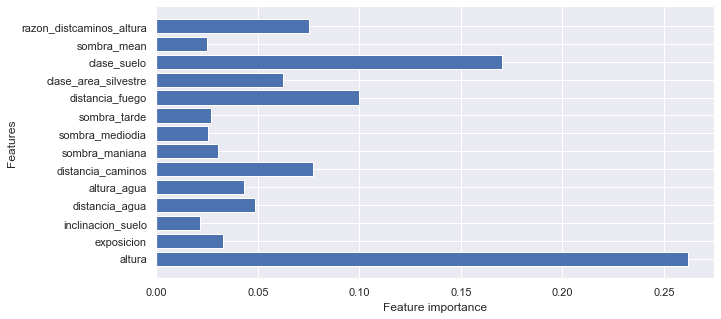

In [89]:
feature_importances = grid_search.best_estimator_.feature_importances_
features = list(train_predictors.columns)

fig = plt.figure(figsize = (10, 5))
 
#Gráfico de barras
plt.barh(features, feature_importances)
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.show()


##### Observaciones 
Las variables con mayor feature importance son altura y clase_suelo, dos de las features con mayor correlación con el target. La variable clase_area_silvestre no tiene mucha importancia a pesar de ser la más correlacionada con el target. Sorpresivamente, la variable razon_distcaminos_alturas resultó con una buena importancia relativa, pero no es el caso de sombra_mean.

En base al histograma, se podría eliminar directamente las variables que tienen menor feature importance. Sin embargo, antes hay que tener en cuenta que el método para calcular feature importance utilizado puede tener un bias, especialmente para atributos con "gran cardinalidad" (gran cantidad de valores únicos). Tal es el caso de clase_suelo que tiene 40 valores únicos correspondientes a 40 categorías distintas. Se intentó emplear permutation_importance pero no se pudo utilizar debido al gran tiempo de ejecución. En función de esto, se decidió eliminar las variables con feature importancia menor a un threshold y entrenar el modelo con los mejores parámetros encontrados anteriormente.

##### Observaciones (ELIMINAR PARA EL INFORME)
Las variables con mayor feature importance son altura y clase_suelo, dos de las features con mayor correlación con el target.

¿Por qué clase_area_silvestre no tiene mucha importancia a pesar de ser la más correlacionada con el target?

Sorpresivamente, la variable razon_distcaminos_alturas resultó con una relativa importancia. Pero no es el caso de sombra_mean.

En base al histograma, podría eliminar directamente las variables que tienen menor feature importance. Sin embargo, antes hay que tener en cuenta que el método para calcular feature importance se basa en calcular the mean and standard deviation of accumulation of the impurity decrease within each tree. Warning: Impurity-based feature importances can be misleading for high cardinality features (many unique values). Tal es el caso de clase_suelo que tiene 40 valores únicos correspondientes a 40 categorías distintas.


In [90]:
#Al final no pude usar permutation_importance debido a que le tomó mucho tiempo correr:
# from sklearn.inspection import permutation_importance

# r = permutation_importance(grid_search.best_estimator_, train_predictors, train_target, n_repeats=30, random_state=0)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{data.feature_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")


###### Observaciones


In [91]:
threshold = 0.03

train_predictors_reduced = train_predictors.copy()
for feature, importance in zip(features, feature_importances):
    if(importance < threshold):
        print("Eliminé la feature: ", feature, " con una feature importance de ", importance)
        train_predictors_reduced = train_predictors_reduced.drop(columns = [feature])



Eliminé la feature:  inclinacion_suelo  con una feature importance de  0.021634939042769075
Eliminé la feature:  sombra_mediodia  con una feature importance de  0.02557963479052168
Eliminé la feature:  sombra_tarde  con una feature importance de  0.026910084631911607
Eliminé la feature:  sombra_mean  con una feature importance de  0.024776694182760423


In [ ]:
# Eliminé la feature:  inclinacion_suelo  con una feature importance de  0.021634939042769075
# Eliminé la feature:  sombra_mediodia  con una feature importance de  0.02557963479052168
# Eliminé la feature:  sombra_tarde  con una feature importance de  0.026910084631911607
# Eliminé la feature:  sombra_mean  con una feature importance de  0.024776694182760423

In [92]:
#Evalúo el score del modelo con los mejores parámetros
RFmodel_score = cross_val_score(grid_search.best_estimator_, train_predictors, train_target,scoring="accuracy", cv=5)
display_scores(RFmodel_score)

Scores: [0.95788624 0.9573215  0.95917709 0.95871936 0.95691753]
Mean: 0.9580043448618843
Standard deviation: 0.0008423722174410649


In [ ]:
# Scores: [0.95788624 0.9573215  0.95917709 0.95871936 0.95691753]
# Mean: 0.9580043448618843
# Standard deviation: 0.0008423722174410649

In [93]:
#Fiteo el modelo con una menor cantidad de variables
#Mejores parámetros
RF_best_params = grid_search.best_estimator_.get_params()

#Modelo reducido
RFmodel_reduced = RandomForestClassifier()
RFmodel_reduced.set_params(**RF_best_params);

#RFmodel_reduced.fit(train_predictors_reduced, train_target)

#Evalúo el score del modelo con los mejores parámetros y una menor cantidad de variables
RFmodel_reduced_score = cross_val_score(RFmodel_reduced, train_predictors_reduced, train_target,scoring="accuracy", cv=5)
display_scores(RFmodel_reduced_score)


Scores: [0.96599435 0.96450182 0.96451526 0.96450134 0.96374834]
Mean: 0.9646522206526124
Standard deviation: 0.0007324576043352895


In [ ]:
# Scores: [0.96599435 0.96450182 0.96451526 0.96450134 0.96374834]
# Mean: 0.9646522206526124
# Standard deviation: 0.0007324576043352895

##### Observaciones

Se obtuvo un mejor rendimiento (menor score mean pero ligeramente mayor standard deviation) empleando una menor cantidad de variables. Para proceder formalmente, la variable threshold, que indica el límite de feature importance debajo del cual se elimina determinada feature, debería ser considerada un hiperparámetro y hacer grid search nuevamente.

#### Mejor modelo de Random Forest
El Accuracy del modelo con menor cantidad de features es ligeramente mayor que el modelo anterior. En base a esto, me quedo con el nuevo modelo y lo entreno

In [94]:
#El mejor modelo de Random Forest es
RFmodel_final = RFmodel_reduced.fit(train_predictors_reduced, train_target)

### XGBoost

Como se emplearán árboles para realizar las estimaciones, tampoco es necesario standarizar las features.

In [ ]:
#Divido el train_set entre train_predictors y train_target
train_predictors = train_set.drop("dosel_forestal", axis=1)
train_target = train_set["dosel_forestal"].copy()

##### Modelo simple con parámetros por default

In [7]:
from xgboost import XGBClassifier

XGBmodel = XGBClassifier()
XGBmodel.fit(train_predictors, train_target);

c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\numpy\__init__.py:148: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. Please install mkl-service package, see http://github.com/IntelPython/mkl-service
  from . import _distributor_init


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\python.exe"
  * The NumPy version is: "1.21.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: No module named 'numpy.core._multiarray_umath'


##### Métricas del modelo

In [96]:
#Error sobre el train set
from sklearn.metrics import accuracy_score

RFmodel_error = accuracy_score(train_target, XGBmodel.predict(train_predictors))
print("Accuracy: ", RFmodel_error*100, " %" )

Accuracy:  88.8962694434285  %


In [ ]:
# Accuracy:  88.8962694434285  %

##### Observaciones
A priori este modelo tarda mucho más tiempo en ejecutar que Random Forest

#### Cross Validation

Al igual que en Random Forest, se determina un score del modelo por default empleando cross validation


In [97]:
train_predictions = XGBmodel.predict(train_predictors)
XGBmodel_scores = cross_val_score(XGBmodel, train_predictors, train_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:19:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:20:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:21:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [98]:
display_scores(XGBmodel_scores)

Scores: [0.87905069 0.87172247 0.87312088 0.87077949 0.87211069]
Mean: 0.8733568452068919
Standard deviation: 0.002944228721388459


In [ ]:
# Scores: [0.87905069 0.87172247 0.87312088 0.87077949 0.87211069]
# Mean: 0.8733568452068919
# Standard deviation: 0.002944228721388459

##### Observaciones
A priori se observa que el modelo de XGBoost por default es bueno en comparación a Random Forest (con accuracy de ~78%), obteniendo mayor accuracy. De todos modos, para hacer una comparación justa es necesario buscar la mejor combinación de hiperparámetros de forma de obtener el "mejor modelo" de XGBoost posible

#### Grid Search

¿Qué parámetros se pueden variar en XGBoost? Hago una lista de los parámetros, junto a una breve explicación, el valor por default y el rango en el que voy a variar cada uno de ellos al hacer grid search
1. n_estimators = 100 (number of trees) (target 500-1000)
* Default: 100
* Variación: 100
2. eta (a.k.a. learning rate)
* Default: 0.3
* Variación: [0.1, 0.3, 0.5, 0.8]
3. max_depth: max depth del tree
* Default: 6
* Variación: [3, 6, 12, 24] 
4. min_samples_split = 2
* Default: 2
* Variación: 2
5. min_samples_leaf = 1
* Default: 1
* Variación: 1
6. subsample: Subsample ratio of the training instances. Entiendo que en cada instancia de training no usa todos los datos de train, sino una parte de ellos. Esto previene el overfitting.
* Default: 1
* Variación: [0.5, 0.75, 1.0]
7. colsample_bytree: subsample ratio of columns when constructing each tree. Entiendo que es el subsample de features que considera para hacer splits en el entrenamiento de un árbol. Si esto es así significaría que estaría haciendo un random forest?
* Default: 1  
* Variación: 1 
8. gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
* Default: 0
* Variación: [0.1, 0.5, 1]  

Los siguientes parámetros son útiles para XGB pero solo para modelos de regresión, no para classifier.
9. alpha: L1 regularization term on weights. Un aumento de este valor produce un modelo más conservativo. A diferencia de L2, le da menor peso a los outliers
* Default: 0
* Variación: [0, 0.5, 1]
10. lambda: L2 regularization term on weights. Un aumento de este valor produce un modelo más conservativo. Pesa mucho los outliers.
* Default: 0
* Variación: [0, 0.5, 1]

In [99]:
#Defino los parámetros que voy a variar

param_grid = [
    {'eta': [0.3, 0.5], 'max_depth':[20, 40, 60], 'subsample':[0.75, 1.0], 'gamma': [0, 0.1]},
  ]


#Defino el modelo
XGBmodel_GS = XGBClassifier()

grid_search = GridSearchCV(XGBmodel_GS, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose = 3); #verbose = 3 muestra el progreso a medida que se hace el gridsearch. Es útil cuando tengo que hacer corridas largas.
grid_search.fit(train_predictors, train_target)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.968) total time= 3.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.967) total time= 3.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:37:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.967) total time= 3.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.966) total time= 3.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.968) total time= 3.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.967) total time= 3.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.968) total time= 3.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.967) total time= 3.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:00:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.966) total time= 3.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.968) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.967) total time= 4.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.967) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.968) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.968) total time= 4.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.967) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.968) total time= 4.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.968) total time= 4.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:48:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:53:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.967) total time= 4.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:58:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.967) total time= 5.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:03:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.967) total time= 5.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:08:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.968) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:14:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:19:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.968) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:24:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.968) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.968) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:34:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.968) total time= 5.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:40:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.967) total time= 5.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:45:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.967) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:53:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:57:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:01:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.965) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:05:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:09:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.966) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:13:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:17:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.966) total time= 3.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:21:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.965) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:25:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.967) total time= 5.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:31:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.966) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.967) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:41:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.967) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:47:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.965) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:52:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.967) total time= 5.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:58:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.967) total time= 5.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:03:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.967) total time= 5.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:09:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.966) total time= 5.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:15:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.965) total time= 5.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:20:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.967) total time= 5.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:26:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.966) total time= 5.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:31:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.967) total time= 5.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:37:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.967) total time= 5.4min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:42:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.965) total time= 5.4min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.967) total time= 6.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.967) total time= 6.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:01:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.967) total time= 6.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:07:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.966) total time= 6.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:13:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.966) total time= 6.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:19:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.966) total time= 3.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:23:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.965) total time= 3.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:27:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.967) total time= 3.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:30:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.966) total time= 3.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:34:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.964) total time= 3.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:38:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.967) total time= 3.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:42:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.967) total time= 3.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:45:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.967) total time= 3.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:49:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.967) total time= 3.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:53:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.966) total time= 3.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:57:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:01:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:05:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.967) total time= 4.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:10:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:14:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.965) total time= 4.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:18:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:23:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:28:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.968) total time= 4.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:32:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:37:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.965) total time= 4.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:42:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.4min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:46:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.4min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:50:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.967) total time= 4.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:55:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.966) total time= 4.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:59:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.965) total time= 4.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:04:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:08:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:13:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.968) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:18:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.967) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:23:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.965) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:27:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.964) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:31:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.964) total time= 3.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:35:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.965) total time= 3.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:39:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.964) total time= 3.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:43:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=0.75;, score=(train=1.000, test=0.963) total time= 3.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:47:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.965) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:51:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.966) total time= 4.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:55:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.966) total time= 3.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:59:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.965) total time= 3.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:03:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0.1, max_depth=20, subsample=1.0;, score=(train=1.000, test=0.964) total time= 4.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:07:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.965) total time= 5.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:13:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.965) total time= 5.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:19:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.966) total time= 5.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:24:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.965) total time= 5.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:30:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=0.75;, score=(train=1.000, test=0.963) total time= 5.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:36:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.965) total time= 6.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:43:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.965) total time= 6.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:49:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.966) total time= 5.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:54:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.966) total time= 5.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:00:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0.1, max_depth=40, subsample=1.0;, score=(train=1.000, test=0.964) total time= 5.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:06:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.965) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:11:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.964) total time= 5.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:16:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.966) total time= 5.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:21:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.965) total time= 5.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:26:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=0.75;, score=(train=1.000, test=0.964) total time= 5.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:32:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.965) total time= 6.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:38:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.965) total time= 6.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:44:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.966) total time= 6.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:50:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.965) total time= 6.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:57:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.5, gamma=0.1, max_depth=60, subsample=1.0;, score=(train=1.000, test=0.964) total time= 6.2min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:03:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [100]:
print("Los mejores parámetros son:",grid_search.best_params_)

#Resultados de cada combinación de hiperparámetros
print("El score de cada combinación de hiperparámetros es:")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

Los mejores parámetros son: {'eta': 0.3, 'gamma': 0, 'max_depth': 60, 'subsample': 1.0}
El score de cada combinación de hiperparámetros es:
0.9668547346790388 {'eta': 0.3, 'gamma': 0, 'max_depth': 20, 'subsample': 0.75}
0.9672177855976154 {'eta': 0.3, 'gamma': 0, 'max_depth': 20, 'subsample': 1.0}
0.9672661935873036 {'eta': 0.3, 'gamma': 0, 'max_depth': 40, 'subsample': 0.75}
0.9676184879502905 {'eta': 0.3, 'gamma': 0, 'max_depth': 40, 'subsample': 1.0}
0.9669300341119424 {'eta': 0.3, 'gamma': 0, 'max_depth': 60, 'subsample': 0.75}
0.9676857185652639 {'eta': 0.3, 'gamma': 0, 'max_depth': 60, 'subsample': 1.0}
0.9659672733704584 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 20, 'subsample': 0.75}
0.9663034318694728 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 20, 'subsample': 1.0}
0.9662146883241253 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 40, 'subsample': 0.75}
0.9663410814593613 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 40, 'subsample': 1.0}
0.9664190717397687 {'eta': 0.3, 'gamma': 0.1, 'max_depth'

In [ ]:
# Los mejores parámetros son: {'eta': 0.3, 'gamma': 0, 'max_depth': 60, 'subsample': 1.0}
# El score de cada combinación de hiperparámetros es:
# 0.9668547346790388 {'eta': 0.3, 'gamma': 0, 'max_depth': 20, 'subsample': 0.75}
# 0.9672177855976154 {'eta': 0.3, 'gamma': 0, 'max_depth': 20, 'subsample': 1.0}
# 0.9672661935873036 {'eta': 0.3, 'gamma': 0, 'max_depth': 40, 'subsample': 0.75}
# 0.9676184879502905 {'eta': 0.3, 'gamma': 0, 'max_depth': 40, 'subsample': 1.0}
# 0.9669300341119424 {'eta': 0.3, 'gamma': 0, 'max_depth': 60, 'subsample': 0.75}
# 0.9676857185652639 {'eta': 0.3, 'gamma': 0, 'max_depth': 60, 'subsample': 1.0}
# 0.9659672733704584 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 20, 'subsample': 0.75}
# 0.9663034318694728 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 20, 'subsample': 1.0}
# 0.9662146883241253 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 40, 'subsample': 0.75}
# 0.9663410814593613 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 40, 'subsample': 1.0}
# 0.9664190717397687 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 60, 'subsample': 0.75}
# 0.9665642919480911 {'eta': 0.3, 'gamma': 0.1, 'max_depth': 60, 'subsample': 1.0}
# 0.9655343015679803 {'eta': 0.5, 'gamma': 0, 'max_depth': 20, 'subsample': 0.75}
# 0.9667122026423074 {'eta': 0.5, 'gamma': 0, 'max_depth': 20, 'subsample': 1.0}
# 0.9661958632760541 {'eta': 0.5, 'gamma': 0, 'max_depth': 40, 'subsample': 0.75}
# 0.9668789362872579 {'eta': 0.5, 'gamma': 0, 'max_depth': 40, 'subsample': 1.0}
# 0.9661689696993406 {'eta': 0.5, 'gamma': 0, 'max_depth': 60, 'subsample': 0.75}
# 0.9667095116501596 {'eta': 0.5, 'gamma': 0, 'max_depth': 60, 'subsample': 1.0}
# 0.9640713382644008 {'eta': 0.5, 'gamma': 0.1, 'max_depth': 20, 'subsample': 0.75}
# 0.9651685601273486 {'eta': 0.5, 'gamma': 0.1, 'max_depth': 20, 'subsample': 1.0}
# 0.9646199493224383 {'eta': 0.5, 'gamma': 0.1, 'max_depth': 40, 'subsample': 0.75}
# 0.9651820075666032 {'eta': 0.5, 'gamma': 0.1, 'max_depth': 40, 'subsample': 1.0}
# 0.9647759278582384 {'eta': 0.5, 'gamma': 0.1, 'max_depth': 60, 'subsample': 0.75}
# 0.9650340970893527 {'eta': 0.5, 'gamma': 0.1, 'max_depth': 60, 'subsample': 1.0}

##### Observaciones

Se afrontó Cross Validation de igual manera que para Random Forest. No se tuvieron en cuenta muchas variaciones de parámetros debido a que al gran tiempo de ejecución necesario para entrenar XGBoost en relación a RandomForest. Las conclusiones que se obtuvieron son
* A mayor max_depth, mejor rendimiento tiene el modelo. Este comportamiento también se observó en RandomForest
* Mayor eta no es sinónimo de menor score. 

En base a lo anterior, se realizó grid search alrededor de los mejores parámetros encontrados
* eta: [0.3, 0.5]
* max_depth: [20, 40, 60]
* subsample: [0.75, 1.0]
* gamma: [0, 0.1]
Se encontró que el mejor modelo corresponde a los parámetros
* eta: 0.3
* max_depth: 60
* subsample: 1.0
* gamma: 0  


con un accuracy de ~ 0.96769







##### Observaciones (ELIMINAR PARA EL INFORME FINAL)

1. Experimento 01:
param_grid = [
    {'max_depth':[3, 6, 12, 24]},
  ]

Dejo todos los parámetros por default salvo
* max_depth :[3, 6, 12, 24]
Se obtuvo como mejor parámetro max_depth: 
con un score de ~
El mayor score obtenido fue de ~
correspondiente a max_depth: 

Los mejores parámetros son: {'max_depth': 24}
El score de cada combinación de hiperparámetros es:
1.0157083370288922 {'max_depth': 3}
0.6747703987883854 {'max_depth': 6}
0.4337960738513713 {'max_depth': 12}
0.4142297049418946 {'max_depth': 24}


2. Experimento 02:
param_grid = [
    {'eta': [0.1, 0.3, 0.5], 'max_depth':[10]},
  ]
Se dejaron todos los parámetros por default salvo
* max_depth: 10
* eta: [0.1, 0.3, 0.5]
Se obtuvo como mejor parámetro eta:
con un score de ~
El mayor score obtenido fue de ~
correspondiente a eta: 

Los mejores parámetros son: {'eta': 0.5, 'max_depth': 10}
El score de cada combinación de hiperparámetros es:
0.5994052135973059 {'eta': 0.1, 'max_depth': 10}
0.46011681515495684 {'eta': 0.3, 'max_depth': 10}
0.4400893219651518 {'eta': 0.5, 'max_depth': 10}

#### Feature Importances

Al igual que en el modelo anterior, se evaluó la importancia de cada feature. Luego se eliminaron aquellas con un valor menor a un threshold y entrenó un nuevo modelo para estos nuevos datos.

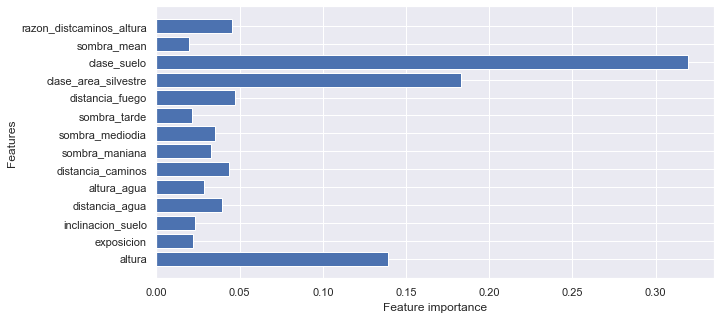

In [102]:
feature_importances = grid_search.best_estimator_.feature_importances_
features = list(train_predictors.columns)

fig = plt.figure(figsize = (10, 5))
 
#Gráfico de barras
plt.barh(features, feature_importances)
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.show()


##### Observaciones

Al igual que en Random Forest, altura y clase_suelo tienen una gran importancia relativa. Pero a diferencia de dicho modelo, clase_area_silvestre cobra mayor preponderancia.

In [105]:
#Elimino las features con un feature importance menor a un threshold
threshold = 0.03

train_predictors_reduced = train_predictors.copy()
for feature, importance in zip(features, feature_importances):
    if(importance < threshold):
        print("Eliminé la feature: ", feature, " con una feature importance de ", importance)
        train_predictors_reduced = train_predictors_reduced.drop(columns = [feature])



Eliminé la feature:  exposicion  con una feature importance de  0.021689657
Eliminé la feature:  inclinacion_suelo  con una feature importance de  0.023368124
Eliminé la feature:  altura_agua  con una feature importance de  0.02876424
Eliminé la feature:  sombra_tarde  con una feature importance de  0.0213258
Eliminé la feature:  sombra_mean  con una feature importance de  0.019524984


In [ ]:
# Eliminé la feature:  exposicion  con una feature importance de  0.021689657
# Eliminé la feature:  inclinacion_suelo  con una feature importance de  0.023368124
# Eliminé la feature:  altura_agua  con una feature importance de  0.02876424
# Eliminé la feature:  sombra_tarde  con una feature importance de  0.0213258
# Eliminé la feature:  sombra_mean  con una feature importance de  0.019524984

In [107]:
XGBmodel_score = cross_val_score(grid_search.best_estimator_, train_predictors, train_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones

c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:39:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:46:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:50:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:55:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:00:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [108]:
display_scores(XGBmodel_score)

Scores: [0.96793062 0.96762135 0.96842813 0.96771504 0.96673345]
Mean: 0.9676857185652639
Standard deviation: 0.00055189968919246


In [ ]:
# Scores: [0.96793062 0.96762135 0.96842813 0.96771504 0.96673345]
# Mean: 0.9676857185652639
# Standard deviation: 0.00055189968919246

In [ ]:
#Fiteo el modelo con una menor cantidad de variables

In [5]:
#Ejecutar en el caso de no haber ejecutado el Grid Search anterior
XGB_best_params = {'eta': 0.3, 'gamma': 0, 'max_depth': 60, 'subsample': 1.0}

In [ ]:
#Ejecutar en el caso de haber ejecutado el Grid Search anterior
#Mejores parámetros
XGB_best_params = grid_search.best_estimator_.get_params()

In [6]:
#Modelo reducido
XGBmodel_reduced = XGBClassifier();
XGBmodel_reduced.set_params(**XGB_best_params);

#Evalúo el score del modelo con los mejores parámetros y una menor cantidad de variables
XGBmodel_reduced_score = cross_val_score(XGBmodel_reduced, train_predictors_reduced, train_target,scoring="accuracy", cv=5)


NameError: name 'XGBClassifier' is not defined

In [110]:
display_scores(XGBmodel_reduced_score)

Scores: [0.96817265 0.96764825 0.96810542 0.96779572 0.96715029]
Mean: 0.9677744653651
Standard deviation: 0.0003671670592698238


In [ ]:
# Scores: [0.96817265 0.96764825 0.96810542 0.96779572 0.96715029]
# Mean: 0.9677744653651
# Standard deviation: 0.0003671670592698238

#### Mejor modelo de XGBoost

El Accuracy del modelo con menor cantidad de features es ligeramente mayor que el modelo anterior. En base a esto, se entrena el nuevo modelo.

In [111]:
#Uso los mejores parámetros encontrados para entrenar el modelo final de XGB:

XGBmodel_final = XGBmodel_reduced
XGBmodel_final.fit(train_predictors, train_target);

c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:32:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### ELECCIÓN FINAL DEL MODELO

El mean_accuracy de cross validation de los mejores modelos fue:
1. Random Forest: 0.9646522206526124  
2. XGBoost: 0.9677744653651  


XGBoost tiene ligeramente mayor accutacy, de modo que el modelo final será XGB

In [112]:
final_model = XGBmodel_final

#### Evalúo test con el mejor modelo

In [113]:
#Calculo el error del modelo sobre el test set
from sklearn.metrics import accuracy_score

#Para evaluar el test tengo que
#(1) Crear las nuevas variables
sombra_mean = (test_set["sombra_maniana"] + test_set["sombra_mediodia"] + test_set["sombra_tarde"])/3
test_set["sombra_mean"] = sombra_mean
razon_distcaminos_altura = test_set["distancia_caminos"]/test_set["altura"]
test_set["razon_distcaminos_altura"] = razon_distcaminos_altura
#(2) Eliminar las variables con feature importance menor a threshold. En el caso de XGBoost:
XGBfeatures_to_eliminate = ["exposicion", "inclinacion_suelo", "altura_agua", "sombra_tarde", "sombra_mean"]
test_set_reduced = test_set.drop(columns = XGBfeatures_to_eliminate)

#(3) Dividir el test_set entre test_predictors y test_target
test_predictors = test_set.drop("dosel_forestal", axis=1)
test_target = test_set["dosel_forestal"].copy()

final_model_accuracy = accuracy_score(test_target, final_model.predict(test_predictors))
print("Accuracy del modelo: ", final_model_accuracy*100, " %")


Accuracy del modelo:  97.12893440330458  %


#### Exporto el modelo

##### Observaciones (ELIMINAR PARA EL INFORME FINAL)

Para instalar pickle5 es necesario tener una versión de Python inferior o igual a la 3.7.0. Esto se puede hacer en anaconda con  
conda install python=3.7.0  
Para luego instalar pickly5  
conda install -c conda-forge pickle5  

Para extraer el .yml del environment de conda se puede ejecutar  
conda env export --from-history>ENV.yml  
o, directamente obtenerlo desde el Anaconda Navigator con la opción Backup


In [2]:
import pickle
with open("final_model.p","wb") as f:
    pickle.dump(final_model,f)

NameError: name 'final_model' is not defined